Segmentation Code

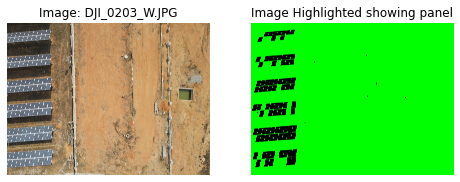

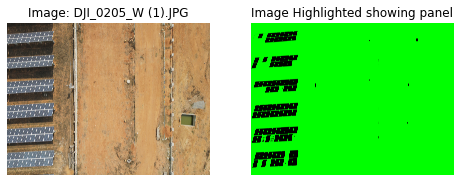

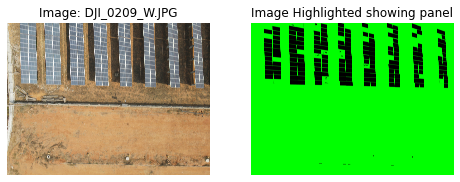

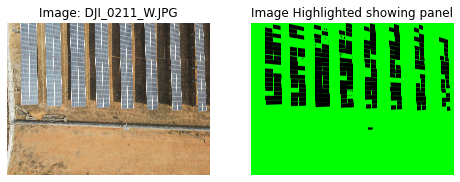

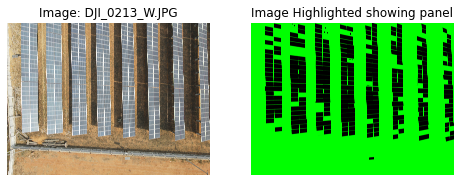

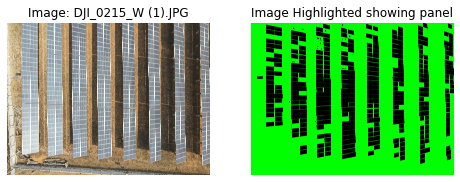

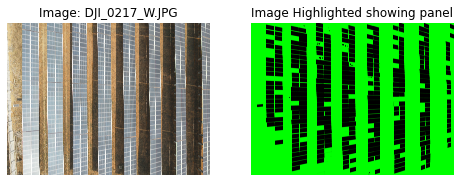

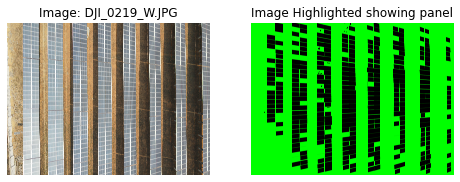

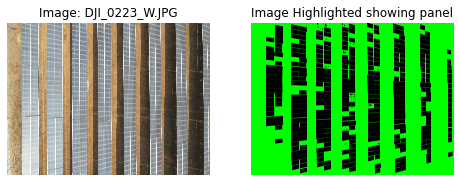

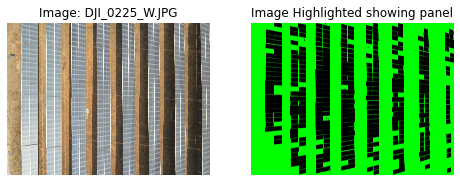

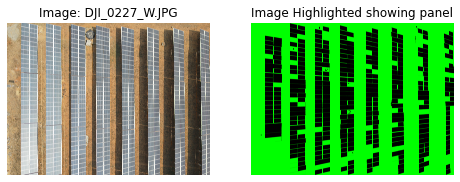

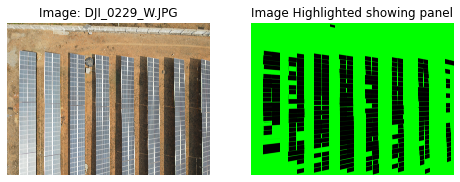

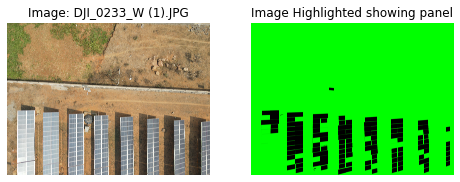

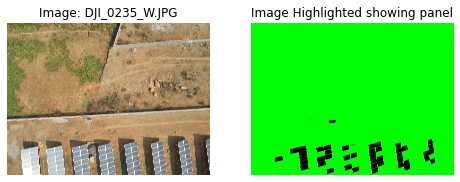

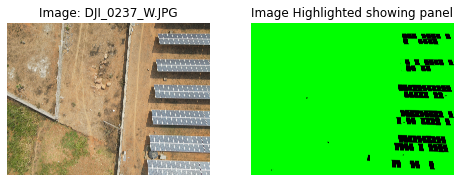

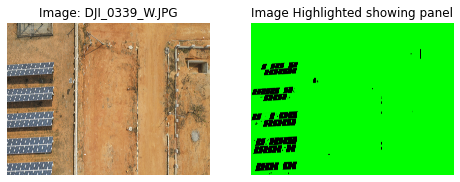

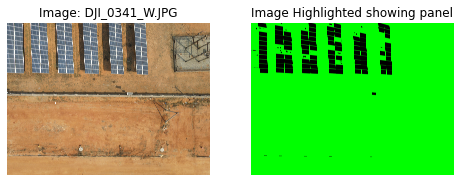

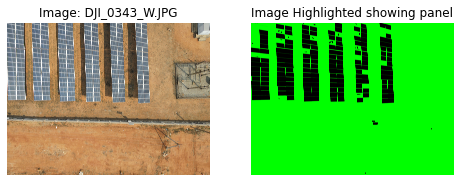

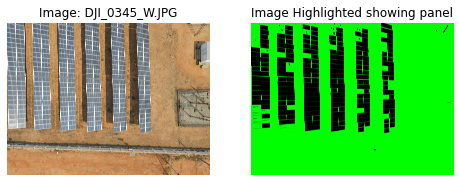

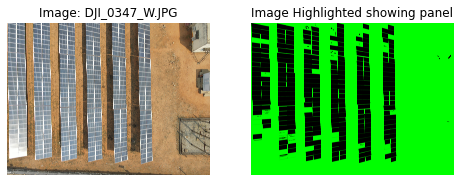

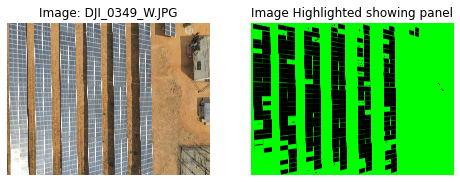

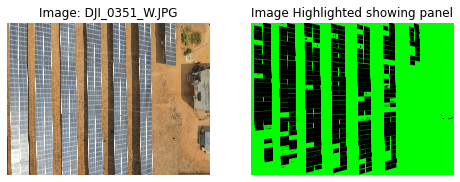

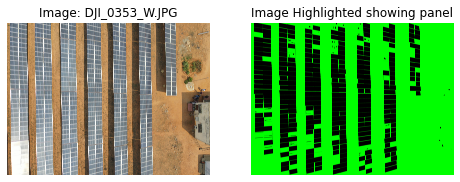

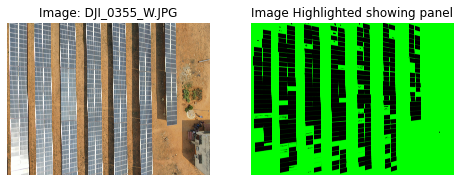

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Path to the folder containing the images
data_dir = "solar_panel_data"
# Create the "ML_cropped" folder if it doesn't exist
ML_cropped_dir = "segmented_images"
os.makedirs(ML_cropped_dir, exist_ok=True)

# Function to classify an image, return segmented image and bounding boxes
def classify_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_contour_area = 1000
    solar_panels = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

    segmented_image = np.zeros_like(image)
    segmented_image[:] = (0, 255, 0)
    cv2.drawContours(segmented_image, solar_panels, -1, (0, 0, 0), -1)

    if len(solar_panels) > 0:
        return True, segmented_image, solar_panels
    else:
        return False, segmented_image, []


# Iterate through the images in the folder, classify, and save cropped solar panels
for filename in os.listdir(data_dir):
    if filename.endswith(".JPG"):
        image_path = os.path.join(data_dir, filename)
        
        # Load the image
        image = cv2.imread(image_path)
        
        # Classify the image and get the segmented image and bounding boxes
        has_solar_panel, segmented_image, solar_panels = classify_image(image)
        
        if has_solar_panel:
            # Create a separate image for all the segmented panels
            all_panels_image = np.zeros_like(image)
            for panel in solar_panels:
                x, y, w, h = cv2.boundingRect(panel)
                all_panels_image[y:y+h, x:x+w] = image[y:y+h, x:x+w]
                
            # Define the path to save the image with all segmented panels
            save_path = os.path.join(ML_cropped_dir, f"{filename}_all_panels.jpg")
            cv2.imwrite(save_path, all_panels_image)

        # Visualize the image and classification
        plt.figure(figsize=(8, 4))
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Image: {filename}")
        plt.axis('off')
        
        plt.subplot(122)
        plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
        if has_solar_panel:
            plt.title("Image Highlighted showing panel")
        else:
            plt.title("Class: No Solar Panel")
        plt.axis('off')
        
        plt.show()

Clustering Code

Top ten segmented images for class 'Clean':


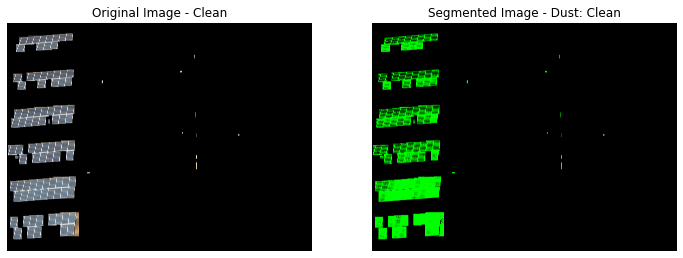

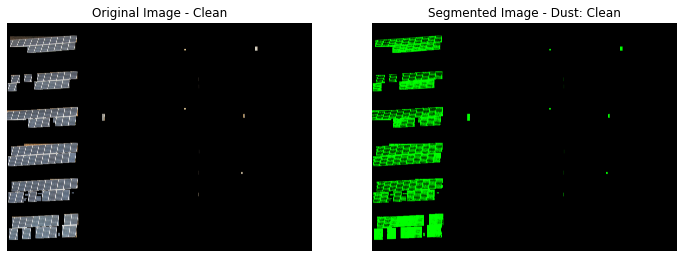

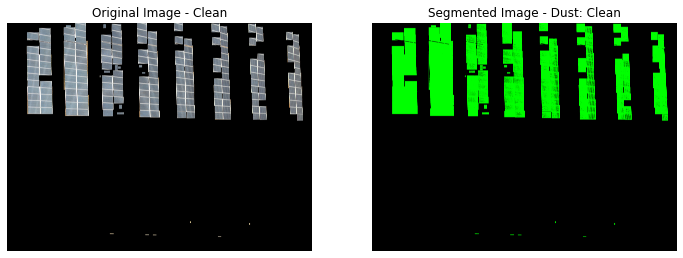

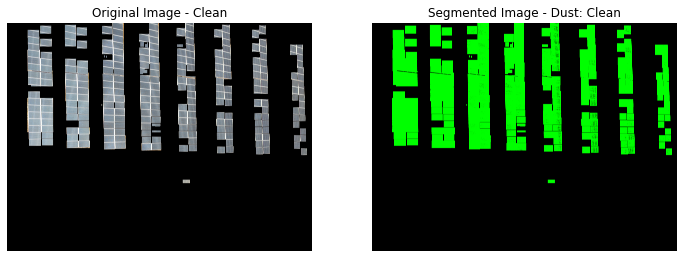

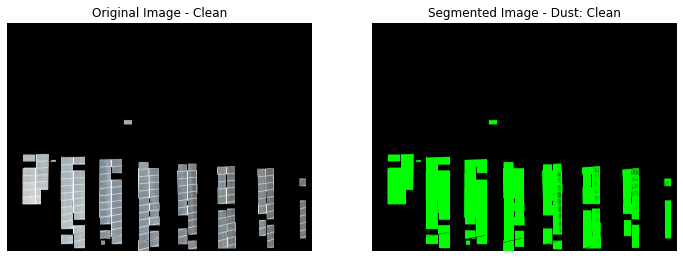

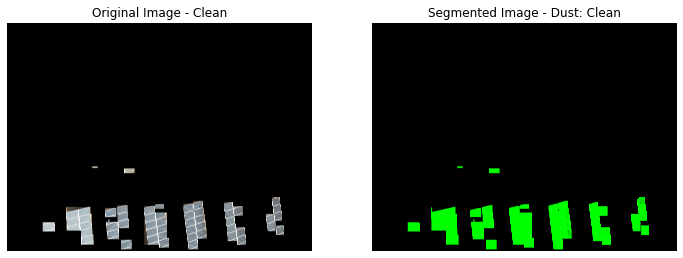

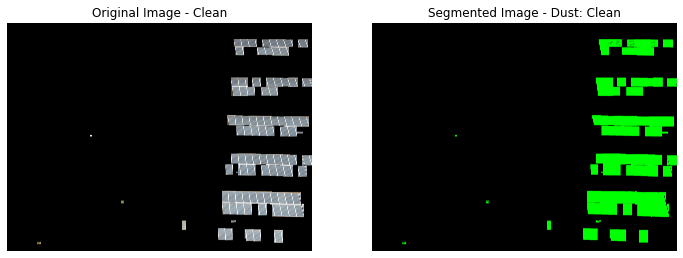

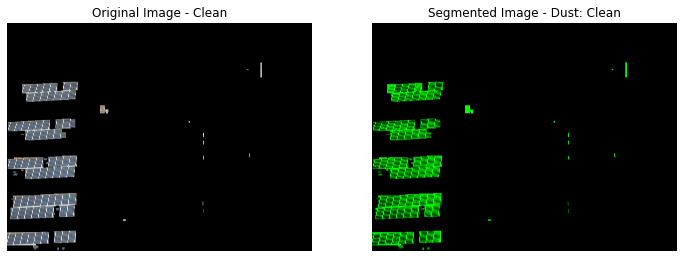

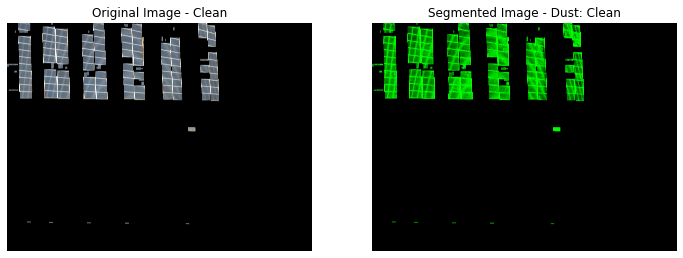

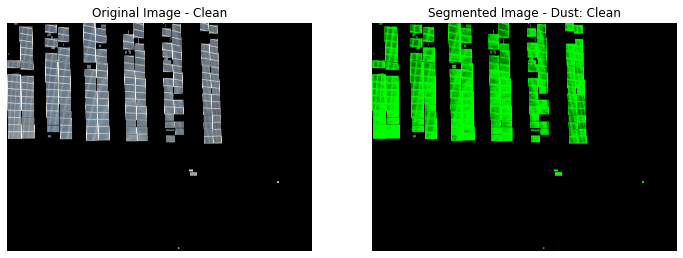

Top ten segmented images for class 'Dusty':


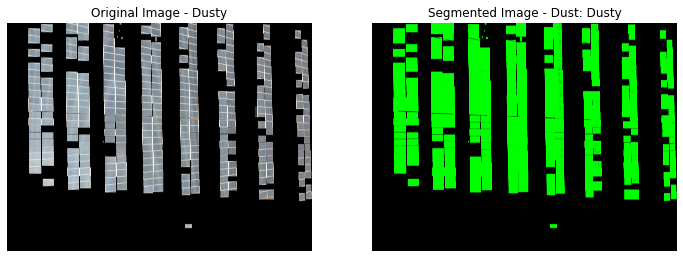

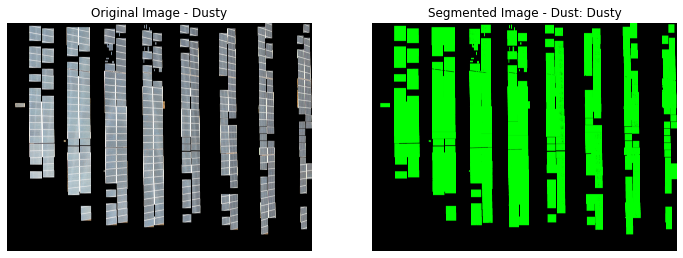

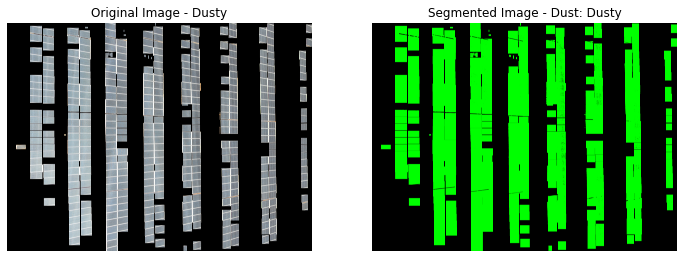

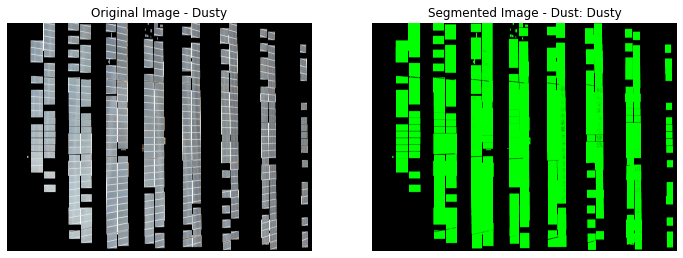

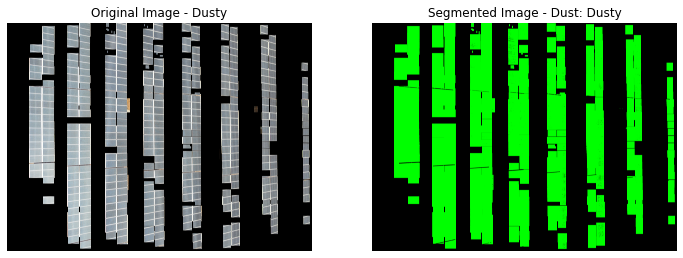

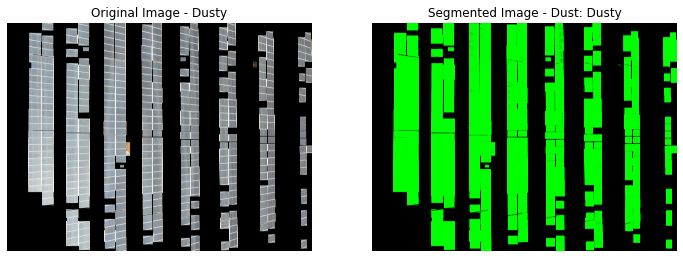

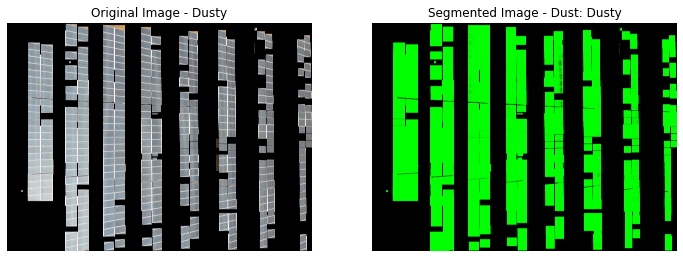

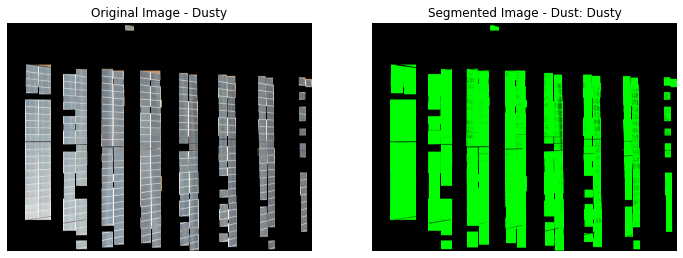

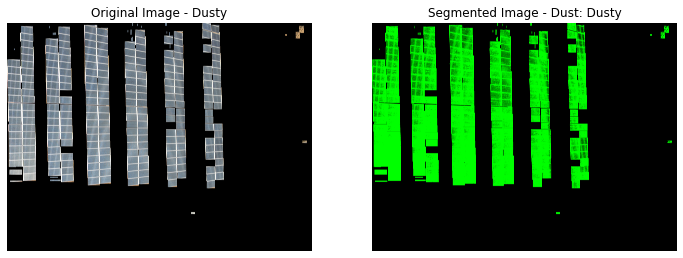

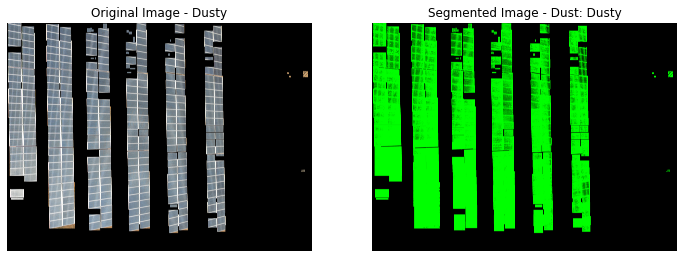

In [3]:
import numpy as np
from sklearn.cluster import KMeans
import cv2
import os
import matplotlib.pyplot as plt

# Function to extract features from an image (e.g., mean color)
def extract_features(image_path):
    image = cv2.imread(image_path)
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Calculate the mean color of the image
    mean_color = np.mean(image, axis=(0, 1))
    return mean_color

# Function to segment the image and label dust presence
def segment_and_label_dust(image_path, cluster_to_class, kmeans):
    image = cv2.imread(image_path)
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply thresholding to segment dust
    _, binary_mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)  # Adjust threshold as needed

    # Create a colored mask for dust regions
    dust_mask = np.zeros_like(image_rgb)
    dust_mask[binary_mask == 255] = [0, 255, 0]  # Set dust regions to green (you can change the color)

    # Overlay labels on the segmented image
    cluster_label = cluster_to_class.get(kmeans.predict([extract_features(image_path)])[0], "Unknown")

    return image_rgb, dust_mask, cluster_label

# Path to the folder containing the solar panel images
data_dir = "segmented_images"

# Create an empty list to store the features of each image
features = []
predicted_labels = []  # Initialize the predicted_labels list

# Create a dictionary to map cluster labels to class names
cluster_to_class = {0: "Clean", 1: "Dusty"}

# Create a dictionary to store the top ten images for each class
top_ten_images = {0: [], 1: []}

# Iterate through the images in the folder
for filename in os.listdir(data_dir):
    if filename.endswith(".jpg"):
        image_path = os.path.join(data_dir, filename)
        features.append(extract_features(image_path))

# Check if images were found
if len(features) == 0:
    print("No images found in the data directory.")
else:
    # Convert the list of features to a NumPy array
    features = np.array(features)

    # Number of clusters (classes) for K-Means
    num_clusters = 2

    # Apply K-Means clustering to classify the images
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(features)

    # Iterate through the images again to display segmented images with dust labels
    for i, filename in enumerate(os.listdir(data_dir)):
        if filename.endswith(".jpg"):
            image_path = os.path.join(data_dir, filename)
            image_rgb, dust_mask, cluster_label = segment_and_label_dust(image_path, cluster_to_class, kmeans)
            predicted_class = cluster_to_class[kmeans.labels_[i]]
            predicted_labels.append(predicted_class)

            # Store the segmented image in the top_ten_images dictionary
            class_label = cluster_to_class[kmeans.labels_[i]]
            if len(top_ten_images[kmeans.labels_[i]]) < 10:
                top_ten_images[kmeans.labels_[i]].append((filename, image_rgb, dust_mask, cluster_label))

    # Display the top ten segmented images for each class
    for i in range(num_clusters):
        print(f"Top ten segmented images for class '{cluster_to_class[i]}':")
        for filename, image_rgb, dust_mask, cluster_label in top_ten_images[i]:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(image_rgb)
            plt.title(f"Original Image - {cluster_label}")
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(dust_mask)
            plt.title(f"Segmented Image - Dust: {cluster_label}")
            plt.axis('off')
            plt.show()

Model Training

Accuracy: 0.6


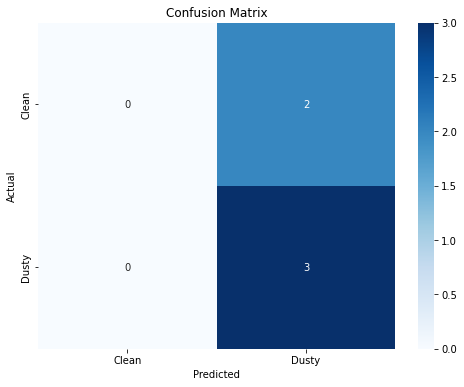

In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have 'features' and 'predicted_labels' from your previous code
# 'features' contain the mean color features
# 'predicted_labels' contain the cluster labels from K-Means (0 for "Clean" and 1 for "Dusty")

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(features, predicted_labels, test_size=0.2, random_state=42)

# Initialize an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM model on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Clean", "Dusty"], yticklabels=["Clean", "Dusty"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


